In [ ]:
## Working with DepMap data

In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import cufflinks as cf
import cufflinks as cf
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
%matplotlib inline

### Read in DepMap mutation rate and cell line info data

In [2]:
#depmap_mutations = pd.read_csv("CCLE_mutations.csv", low_memory = False)
depmap_info = pd.read_csv("sample_info.csv")
#depmap_crispr_raw = pd.read_csv("Achilles_gene_effect.csv")
depmap_expression_raw = pd.read_csv("CCLE_expression.csv")

In [ ]:
depmap_mutations.head()

In [ ]:
depmap_info.head()

In [ ]:
depmap_crispr_raw.head()

In [ ]:
depmap_crispr_raw.rename(columns={"Unnamed: 0": "DepMap_ID"})

# Move DepMap_ID to last columnn
depmap_ids = depmap_crispr_raw["Unnamed: 0"]
#df1 = depmap_crispr_raw.pop('DepMap_ID') # remove column b and store it in df1
#depmap_crispr_raw['DepMap_ID'] = df1 # add b series as a 'new' column.
depmap_crispr_raw['DepMap_ID'] = depmap_ids


In [3]:
print(len(depmap_expression_raw.columns))
depmap_expression_cellIDs = depmap_expression_raw["Unnamed: 0"]
depmap_expression_raw.pop('Unnamed: 0')
depmap_expression_raw['DepMap_ID'] = depmap_expression_cellIDs
depmap_expression_raw.head()
print(len(depmap_expression_raw.columns))
nGenes = len(depmap_expression_raw.columns)-1

19145
19145


### Retrieve cell lines of interest
The cell line names are contained in the `depmap_info` data frame, so we need to match the cell line names with the ACH-___ ID in `depmap_X`.

In [4]:
depmap_expression = pd.merge(depmap_expression_raw,depmap_info,on = "DepMap_ID", how= "left")

In [5]:
depmap_expression.head()

,TSPAN6 (7105),TNMD (64102),DPM1 (8813),SCYL3 (57147),C1orf112 (55732),FGR (2268),CFH (3075),FUCA2 (2519),GCLC (2729),NFYA (4800),...,culture_medium,cas9_activity,RRID,sample_collection_site,primary_or_metastasis,disease,disease_subtype,age,Sanger_model_ID,additional_info
0,0.000000,0.0,4.667324,1.761285,3.554589,4.358959,0.641546,2.201634,1.941106,2.150560,...,NaN,NaN,CVCL_2541,haematopoietic_and_lymphoid_tissue,NaN,Lymphoma,T-cell,NaN,NaN,NaN
1,4.934988,0.0,6.635464,1.929791,2.503349,0.000000,4.883621,6.772546,3.889474,4.139961,...,IMDM + 15% FBS + 1% L-Glutamine + 1% Pen-Strep...,17,NaN,soft_tissue,NaN,Liposarcoma,WD/DDLPS,NaN,NaN,NaN
2,0.839960,0.0,5.376082,2.687061,4.440288,4.938286,0.536053,3.584963,2.935460,3.157044,...,NaN,NaN,CVCL_1902,pleural_effusion,Metastasis,Lymphoma,Diffuse Large B-cell Lymphoma (DLBCL),41.0,SIDM00413,NaN
3,3.722466,0.0,6.029674,2.192194,2.533563,0.150560,5.933809,6.973382,5.192194,3.258519,...,NaN,NaN,CVCL_2019,fibroblast,NaN,Fibroblast,Lung,62.0,NaN,NaN
4,4.632268,0.0,6.704180,2.792855,4.079805,0.097611,1.150560,5.729553,4.802193,4.372256,...,RPMI-1640: 90.0%,5.7,CVCL_8930,salivary_gland,NaN,Head and Neck Cancer,"Squamous Cell Carcinoma, tongue",39.0,NaN,NaN


In [6]:
a375_all_data = depmap_expression.loc[depmap_expression["CCLE_Name"] == "A375_SKIN", :]

In [7]:
a375_expression = a375_all_data.iloc[0, 0:nGenes]
a375_expression

TSPAN6 (7105)               4.0321
TNMD (64102)                     0
DPM1 (8813)                7.57796
SCYL3 (57147)              2.62527
C1orf112 (55732)           4.82273
                           ...    
EEF1AKMT4 (110599564)      2.33914
TBCE (6905)                5.47994
OOSP4A (112577462)               0
ARHGAP11B (89839)          1.41684
OOSP3 (112577461)        0.0426443
Name: 782, Length: 19144, dtype: object

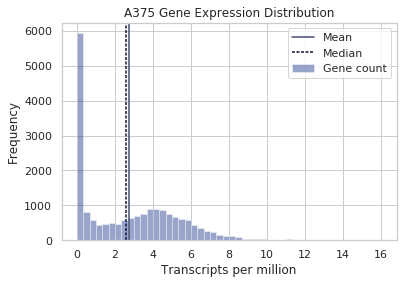

2.7310791125790446


In [8]:
sns.set(style="whitegrid", palette="dark")

mean_color = '#434d6e'
median_color = '#0a1338'

fig = sns.distplot(a375_expression, rug = False, kde = False, label = 'Gene count')
fig.axvline(a375_expression.mean(), label = 'Mean', color = mean_color)
fig.axvline(a375_expression.median(), label = 'Median', color = median_color, dashes = (2,1,2,1))
fig.set(xlabel='Transcripts per million', ylabel='Frequency', title = "A375 Gene Expression Distribution")
fig.legend()
plt.show()
print(a375_expression.mean())
#fig.figure.savefig("L4_population_distribution.pdf")

2.5217430237905


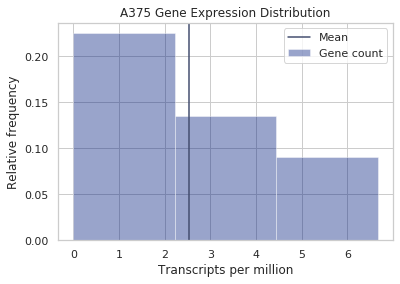

In [35]:
# Randomly sample n = 100 points from the gene expression data
n = 10
sample_1 = np.random.choice(a375_expression, n, replace = False)
print(sample_1.mean())

# Plot histogram
# if we want relative frequency, set norm_hist = True
fig_1 = sns.distplot(sample_1, rug = False, kde = False, label = 'Gene count', norm_hist = True)
fig_1.axvline(sample_1.mean(), label = 'Mean', color = mean_color)
#fig_1.axvline(np.median(sample_1), label = 'Median', color = median_color, dashes = (2,1,2,1))
fig_1.set(xlabel='Transcripts per million', ylabel='Relative frequency', title = "A375 Gene Expression Distribution")
fig_1.legend()
plt.show()
fig_1.figure.savefig("L4_expression_sample_n10_4.pdf")

In [42]:
## Sample many times and plot the distribution of means
n = 10
n_replicates = 1000
sample_mean_vec = np.zeros((1,n_replicates))

for rep in range(n_replicates):
    
    # Sample randomly n points from the population
    sample_i = np.random.choice(a375_expression, n, replace = False)
    
    # Compute the mean of the sample
    sample_i_mean = np.mean(sample_i)
    
    # Store the mean
    sample_mean_vec[0, rep] = sample_i_mean

print("done with experiment")
    



done with experiment


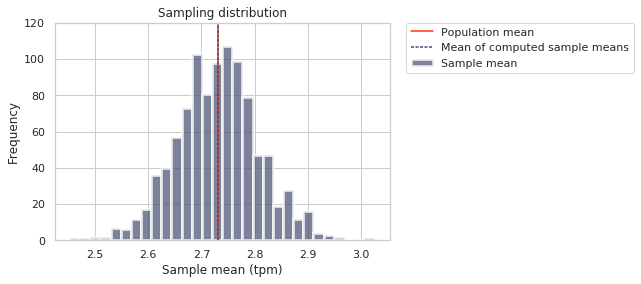

In [41]:
# Histogram of the means

fig_2 = sns.distplot(sample_mean_vec, rug = False, kde = False, label = 'Sample mean',hist_kws={"linewidth": 3,
                            "alpha": 0.7, "color": mean_color})
fig_2.axvline(a375_expression.mean(), label = 'Population mean', color = '#ff3800')
fig_2.axvline(np.mean(sample_mean_vec), label = 'Mean of computed sample means', color = mean_color, dashes = (2,1,2,1))
fig_2.set(xlabel='Sample mean (tpm)', ylabel='Frequency', title = "Sampling distribution", ylim = (0,120))
fig_2.legend()
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
lgd = plt.legend(loc=2, bbox_to_anchor=(1.05,1), borderaxespad = 0.0)
plt.show()
#fig_2.figure.savefig("L4_expression_distofsamplemeans_n1000.pdf",bbox_extra_artists=(lgd,), bbox_inches='tight')

done with experiment


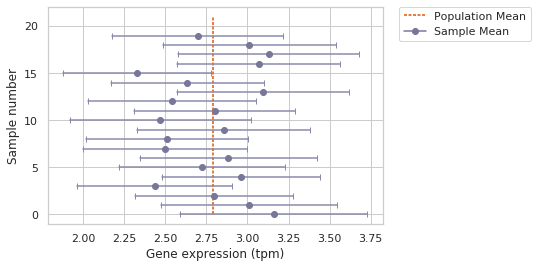

In [92]:
## Make horizontal boxplots
n = 100
n_replicates = 20
sample_vec = np.zeros((n,n_replicates))

for rep in range(n_replicates):
    
    # Sample randomly n points from the population
    sample_i = np.random.choice(a375_expression, n, replace = False)
     
    # Store the sample
    sample_vec[:, rep] = sample_i
    

print("done with experiment")


plt.plot([np.mean(sample_mean_vec), np.mean(sample_mean_vec)], [0,21], label = 'Population Mean',
         color = "#df5500", dashes = (2,1,2,1))
for rep in range(n_replicates):
    # Calculate standard error of the mean
    sem_sample = sp.stats.sem(sample_vec[:,rep])  # Check this is the correct SEM def!
    ci_left = np.mean(sample_vec[:, rep]) - 2*sem_sample
    ci_right = np.mean(sample_vec[:, rep]) + 2*sem_sample
    plt.plot([ci_left, ci_right], [rep, rep], marker = '|', color = '#8989aa')
    if rep == 0:
        plt.plot([np.mean(sample_vec[:, rep])], rep, marker = 'o', color = '#777799', label = 'Sample Mean')
    else:
        plt.plot([np.mean(sample_vec[:, rep])], rep, marker = 'o', color = '#777799')
    

    
plt.legend()
plt.xlabel('Gene expression (tpm)')
plt.ylabel('Sample number')
lgd = plt.legend(loc=2, bbox_to_anchor=(1.05,1), borderaxespad = 0.0)
plt.savefig("L4_uncertainty_20samples.pdf",bbox_extra_artists=(lgd,), bbox_inches='tight')


0.28443261101844075
3.1603681216834296
2.8300687466678256
2.591502899646548 3.729233343720311


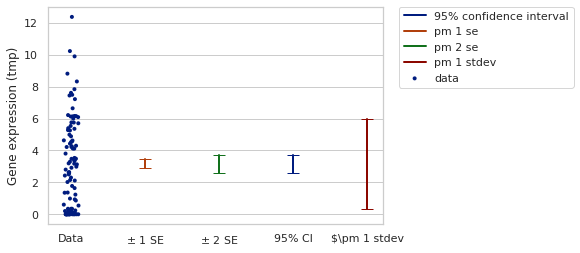

In [94]:
## Plot that cool one that has the CI, SEM, standdev, etc.

fig_4 = sns.stripplot(sample_vec[:, 0], jitter = 0.05, size = 4, orient = 'v', label = 'data')
sem_sample = sp.stats.sem(sample_vec[:,0], ddof = 1)
print(sem_sample)
sample_mean = np.mean(sample_vec[:,0])
print(sample_mean)
ci_left = np.mean(sample_vec[:, 0]) - 2*sem_sample
ci_right = np.mean(sample_vec[:, 0]) + 2*sem_sample
stdev_sample = np.std(sample_vec[:, 0])
print(np.std(sample_vec[:, 0]))
print(ci_left, ci_right)

    
plt.plot([1.5, 1.5], [ci_left, ci_right], label = '95% confidence interval', lw = 2, marker = '_', markersize = 12)
plt.plot([0.5, 0.5], [sample_mean - sem_sample, sample_mean + sem_sample], label = 'pm 1 se', lw = 2, marker = '_', markersize = 12)
plt.plot([1, 1], [sample_mean - 2*sem_sample, sample_mean + 2*sem_sample], label = 'pm 2 se', lw = 2, marker = '_', markersize = 12)
plt.plot([2, 2], [sample_mean - stdev_sample, sample_mean + stdev_sample], label = 'pm 1 stdev', lw = 2, marker = '_', markersize = 12)

# confidence interval

lgd = plt.legend(loc=2, bbox_to_anchor=(1.05,1), borderaxespad = 0.0)
plt.ylabel('Gene expression (tmp)')
plt.xticks(np.arange(5)/2, ('Data', r'$\pm$ 1 SE', r'$\pm$ 2 SE', '95% CI', r'$\pm 1 stdev'))
plt.savefig('L4_expression_uncertainty.pdf',bbox_extra_artists=(lgd,), bbox_inches='tight')


In [ ]:
fig_5 = sns.stripplot(a375_expression, jitter = 0.05, size = 1, orient = 'v')
fig_5.set(xlabel='A375', ylabel='Transcripts per million', title = 'A375 gene expression')
fig_5.figure.savefig('L4_A375_expression_all.pdf')

In [63]:
v

array([[1.86509767, 1.92525175, 2.27156303, 2.17147008, 1.9210666 ,
        1.81240146, 2.68410394, 2.58987139, 2.34112671, 3.41539906,
        2.98739618, 2.11269963, 3.10431615, 2.30816694, 1.13108473,
        3.46058423, 3.39261603, 2.88030593, 2.35780273, 3.99237075,
        3.76469223, 3.88744018, 2.06884944, 1.35807003, 3.66488376,
        3.69705767, 3.0928963 , 2.70095316, 1.63992552, 2.76625596,
        2.57914859, 3.10112965, 3.61167824, 1.90004758, 2.72037127,
        2.88487293, 2.06061453, 3.44690519, 3.52328461, 3.32399145,
        3.07883976, 2.60176467, 3.98499901, 1.9649275 , 3.84149083,
        0.84487756, 4.28969984, 2.02378236, 5.28297481, 2.82871498,
        3.07437294, 2.64462259, 2.77153736, 3.5043152 , 1.84432237,
        2.05498986, 2.16630752, 2.54241488, 2.54370356, 4.20405099,
        4.18732131, 2.71128929, 3.60450766, 4.30257475, 2.84994423,
        2.04501438, 3.11291966, 4.02739397, 2.61275677, 4.18251357,
        2.28617609, 1.69844287, 3.41246877, 2.69